**Business Need for Fraud Detection in Financial Transactions**

Problem Statement

Financial institutions, e-commerce platforms, and online payment systems face significant losses due to fraudulent transactions. Fraudsters use stolen credit card details, fake identities, and other malicious tactics to perform unauthorized transactions.

Why is Fraud Detection Important?

Financial Loss Prevention: Banks and businesses lose billions annually due to fraud.

Customer Trust & Retention: Ensuring transaction security enhances customer confidence.

Regulatory Compliance: Companies must comply with financial regulations to prevent fraud.

Operational Efficiency: Detecting fraud early saves investigation costs and reduces chargebacks.

Business Impact

Reduced Chargebacks & Losses 🏦

Early fraud detection minimizes financial losses.

Enhanced Security & Compliance 🔐

Detecting anomalies ensures compliance with anti-fraud regulations.

Improved Customer Experience 💳

Preventing fraud protects customer accounts and builds trust.

Objective of the Project

Analyze transaction data to identify patterns of fraudulent behavior.

Develop a Machine Learning model to detect fraud in real-time.

Improve accuracy using feature engineering and various ML algorithms.

In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)

# Imbalance handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 4)

In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\hp\Downloads\Finance Work\fraud_detection_sample.csv")

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())

print("\nClass distribution (counts):")
print(df["Class"].value_counts())
print("\nClass distribution (%):")
print(df["Class"].value_counts(normalize=True) * 100)

df.head()

Shape: (500, 13)

Columns: ['Time', 'Amount', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'Class']

Class distribution (counts):
Class
0    480
1     20
Name: count, dtype: int64

Class distribution (%):
Class
0    96.0
1     4.0
Name: proportion, dtype: float64


,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Class
0,15795,4292.21,0.593101,-1.592994,0.126380,0.189706,0.333860,-1.535040,0.872197,-2.386930,-0.190872,-1.846573,0
1,860,2145.54,-0.309546,0.440475,1.938929,-0.661982,1.431367,-1.880010,-0.315087,-0.495878,-0.198196,-0.428655,0
2,76820,3754.60,0.326133,-0.019638,-1.000331,0.425887,1.081767,0.712712,-0.571746,1.097300,0.510157,1.029441,0
3,54886,3772.96,-1.251114,0.552490,-0.677745,0.019148,-1.312219,-1.883150,0.332608,-1.565648,1.272570,-0.336895,0
4,6265,516.52,0.924027,0.223914,0.513908,-0.641487,0.622070,-0.372319,0.933128,-3.007632,0.126314,-0.846434,0


## EDA: Check class distribution

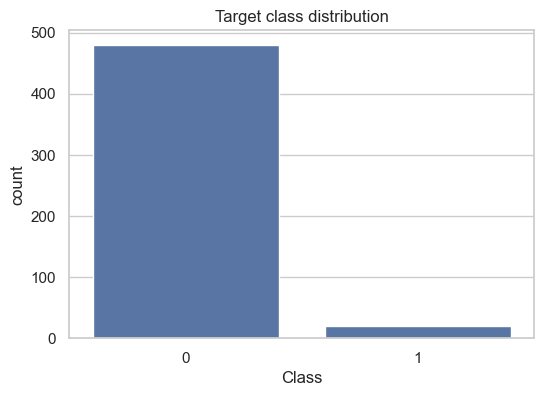

In [3]:
# Quick class imbalance plot
sns.countplot(x="Class", data=df)
plt.title("Target class distribution")
plt.show()

In [4]:
# Features and target
X = df.drop("Class", axis=1)
y = df["Class"]

# Stratified split to preserve fraud ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# Standardize all features (they are numeric already)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train shape:", X_train_scaled.shape)
print("Test shape:", X_test_scaled.shape)

Train shape: (375, 12)
Test shape: (125, 12)


In [5]:
results = []

# 1) Logistic Regression with class weights
lr_weighted = LogisticRegression(
    class_weight="balanced",
    max_iter=500,
    random_state=42
)
lr_weighted.fit(X_train_scaled, y_train)
y_pred_lr = lr_weighted.predict(X_test_scaled)
y_proba_lr = lr_weighted.predict_proba(X_test_scaled)[:, 1]

# 2) Random Forest with class weights
rf_weighted = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_weighted.fit(X_train, y_train)  # trees handle scale reasonably
y_pred_rf = rf_weighted.predict(X_test)
y_proba_rf = rf_weighted.predict_proba(X_test)[:, 1]

# 3) SMOTE + Logistic Regression pipeline
smote_lr = ImbPipeline(steps=[
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=500, random_state=42))
])
smote_lr.fit(X_train, y_train)
y_pred_smote = smote_lr.predict(X_test)
y_proba_smote = smote_lr.predict_proba(X_test)[:, 1]

def eval_model(name, y_true, y_pred, y_proba):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    roc = roc_auc_score(y_true, y_proba)
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(rec, prec)

    print(f"\n=== {name} ===")
    print("Confusion matrix [tn, fp; fn, tp]:")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3))
    print(f"ROC-AUC: {roc:.3f}")
    print(f"PR-AUC : {pr_auc:.3f}")

    results.append({
        "model": name,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "roc_auc": roc,
        "pr_auc": pr_auc
    })

# Evaluate all three
eval_model("LogReg_weighted", y_test, y_pred_lr, y_proba_lr)
eval_model("RF_weighted", y_test, y_pred_rf, y_proba_rf)
eval_model("SMOTE_LogReg", y_test, y_pred_smote, y_proba_smote)

# Summary table
results_df = pd.DataFrame(results)
results_df


=== LogReg_weighted ===
Confusion matrix [tn, fp; fn, tp]:
[[73 47]
 [ 4  1]]

Classification report:
              precision    recall  f1-score   support

           0      0.948     0.608     0.741       120
           1      0.021     0.200     0.038         5

    accuracy                          0.592       125
   macro avg      0.484     0.404     0.389       125
weighted avg      0.911     0.592     0.713       125

ROC-AUC: 0.383
PR-AUC : 0.032

=== RF_weighted ===
Confusion matrix [tn, fp; fn, tp]:
[[120   0]
 [  5   0]]

Classification report:
              precision    recall  f1-score   support

           0      0.960     1.000     0.980       120
           1      0.000     0.000     0.000         5

    accuracy                          0.960       125
   macro avg      0.480     0.500     0.490       125
weighted avg      0.922     0.960     0.940       125

ROC-AUC: 0.422
PR-AUC : 0.031

=== SMOTE_LogReg ===
Confusion matrix [tn, fp; fn, tp]:
[[72 48]
 [ 4  1]]

Cla

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

,model,tn,fp,fn,tp,roc_auc,pr_auc
0,LogReg_weighted,73,47,4,1,0.383333,0.031505
1,RF_weighted,120,0,5,0,0.421667,0.031244
2,SMOTE_LogReg,72,48,4,1,0.350000,0.028974


In [6]:
def evaluate_thresholds(y_true, y_proba, fn_cost=10, fp_cost=1):
    thresholds = np.linspace(0.1, 0.9, 9)
    rows = []

    for thr in thresholds:
        y_hat = (y_proba >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        cost = fn_cost * fn + fp_cost * fp
        rows.append({
            "threshold": thr,
            "tn": tn, "fp": fp, "fn": fn, "tp": tp,
            "cost": cost
        })

    return pd.DataFrame(rows)

# Example: tune threshold on SMOTE + Logistic regression
thr_df = evaluate_thresholds(y_test, y_proba_smote, fn_cost=10, fp_cost=1)
thr_df.sort_values("cost")

,threshold,tn,fp,fn,tp,cost
8,0.9,118,2,5,0,52
7,0.8,110,10,5,0,60
6,0.7,101,19,5,0,69
5,0.6,86,34,4,1,74
4,0.5,72,48,4,1,88
3,0.4,59,61,4,1,101
2,0.3,41,79,3,2,109
1,0.2,26,94,2,3,114
0,0.1,15,105,1,4,115
